## Incrocio di medie mobili - simple moving average crossover

Guardare su OANDA o IBKR la SMA50 e la SMA200 e vedere gli incroci.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

C:\Users\Paolo\AppData\Local\Temp\ipykernel_4688\1123596123.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# WITH OANDA
import tpqoa
api = tpqoa.tpqoa("oandaMY.cfg")

In [5]:
# WITH IBKR
# ib.disconnect()
import pandas as pd
from ib_insync import *
util.startLoop()  # not necessary in scripts
ib = IB()
ib.connect()

<IB connected to 127.0.0.1:7497 clientId=1>

In [6]:
# WITH OANDA
df = api.get_history(instrument = "EUR_USD", start = "2016-09-24", end = "2024-09-24", granularity = "D", price = "B")
# we change the column names to match IBKR
df.rename(columns={"o":"open","h":"high","l":"low","c":"close","time":"date"},inplace=True)
df.index.names = ['date']
df = df.close.to_frame()
df.head(5)

close
date                        
2016-09-25 21:00:00  1.12528
2016-09-26 21:00:00  1.12149
2016-09-27 21:00:00  1.12163
2016-09-28 21:00:00  1.12223
2016-09-29 21:00:00  1.12375

In [21]:
# WITH IBKR
df = pd.DataFrame(ib.reqHistoricalData( Forex("EURUSD"), endDateTime = "20240924 00:00:00", 
                                  barSizeSetting="1 day", durationStr="8 Y", 
                                  whatToShow= "BID", useRTH = True, formatDate=2 )).set_index("date")
df.index=pd.to_datetime(df.index)
df = df.close.to_frame()
df.head(5)

close
date               
2016-09-27  1.12145
2016-09-28  1.12170
2016-09-29  1.12210
2016-09-30  1.12410
2016-10-03  1.12105

In [22]:
df["SMA_s"]=df.close.rolling(50).mean()
df["SMA_l"]=df.close.rolling(200).mean()

In [23]:
df.dropna(inplace=True)
df.head()

close     SMA_s     SMA_l
date                                   
2017-07-04  1.13430  1.113788  1.083018
2017-07-05  1.13520  1.114685  1.083087
2017-07-06  1.14235  1.115786  1.083190
2017-07-07  1.13975  1.116791  1.083278
2017-07-10  1.13995  1.117792  1.083357

<Axes: xlabel='date'>

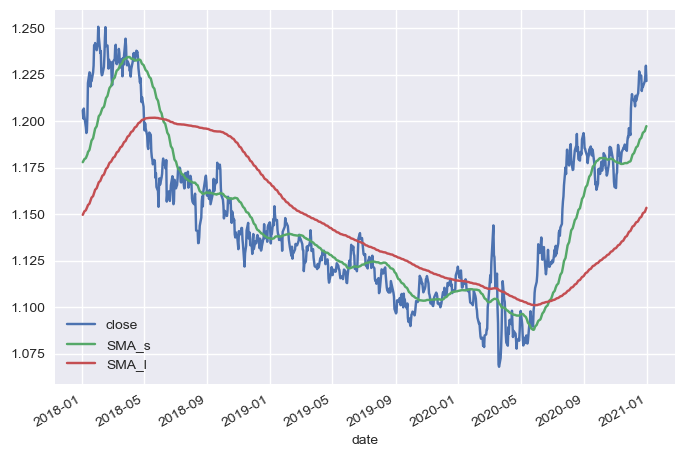

In [42]:
df.loc["2018":"2020"].plot()

In [43]:
df["position"]=np.where(df.SMA_s > df.SMA_l,+1,-1) # +1 quando compriamo, -1 quando vendiamo

In [44]:
df.head()

close     SMA_s     SMA_l  position
date                                             
2017-07-04  1.13430  1.113788  1.083018         1
2017-07-05  1.13520  1.114685  1.083087         1
2017-07-06  1.14235  1.115786  1.083190         1
2017-07-07  1.13975  1.116791  1.083278         1
2017-07-10  1.13995  1.117792  1.083357         1

<Axes: xlabel='date'>

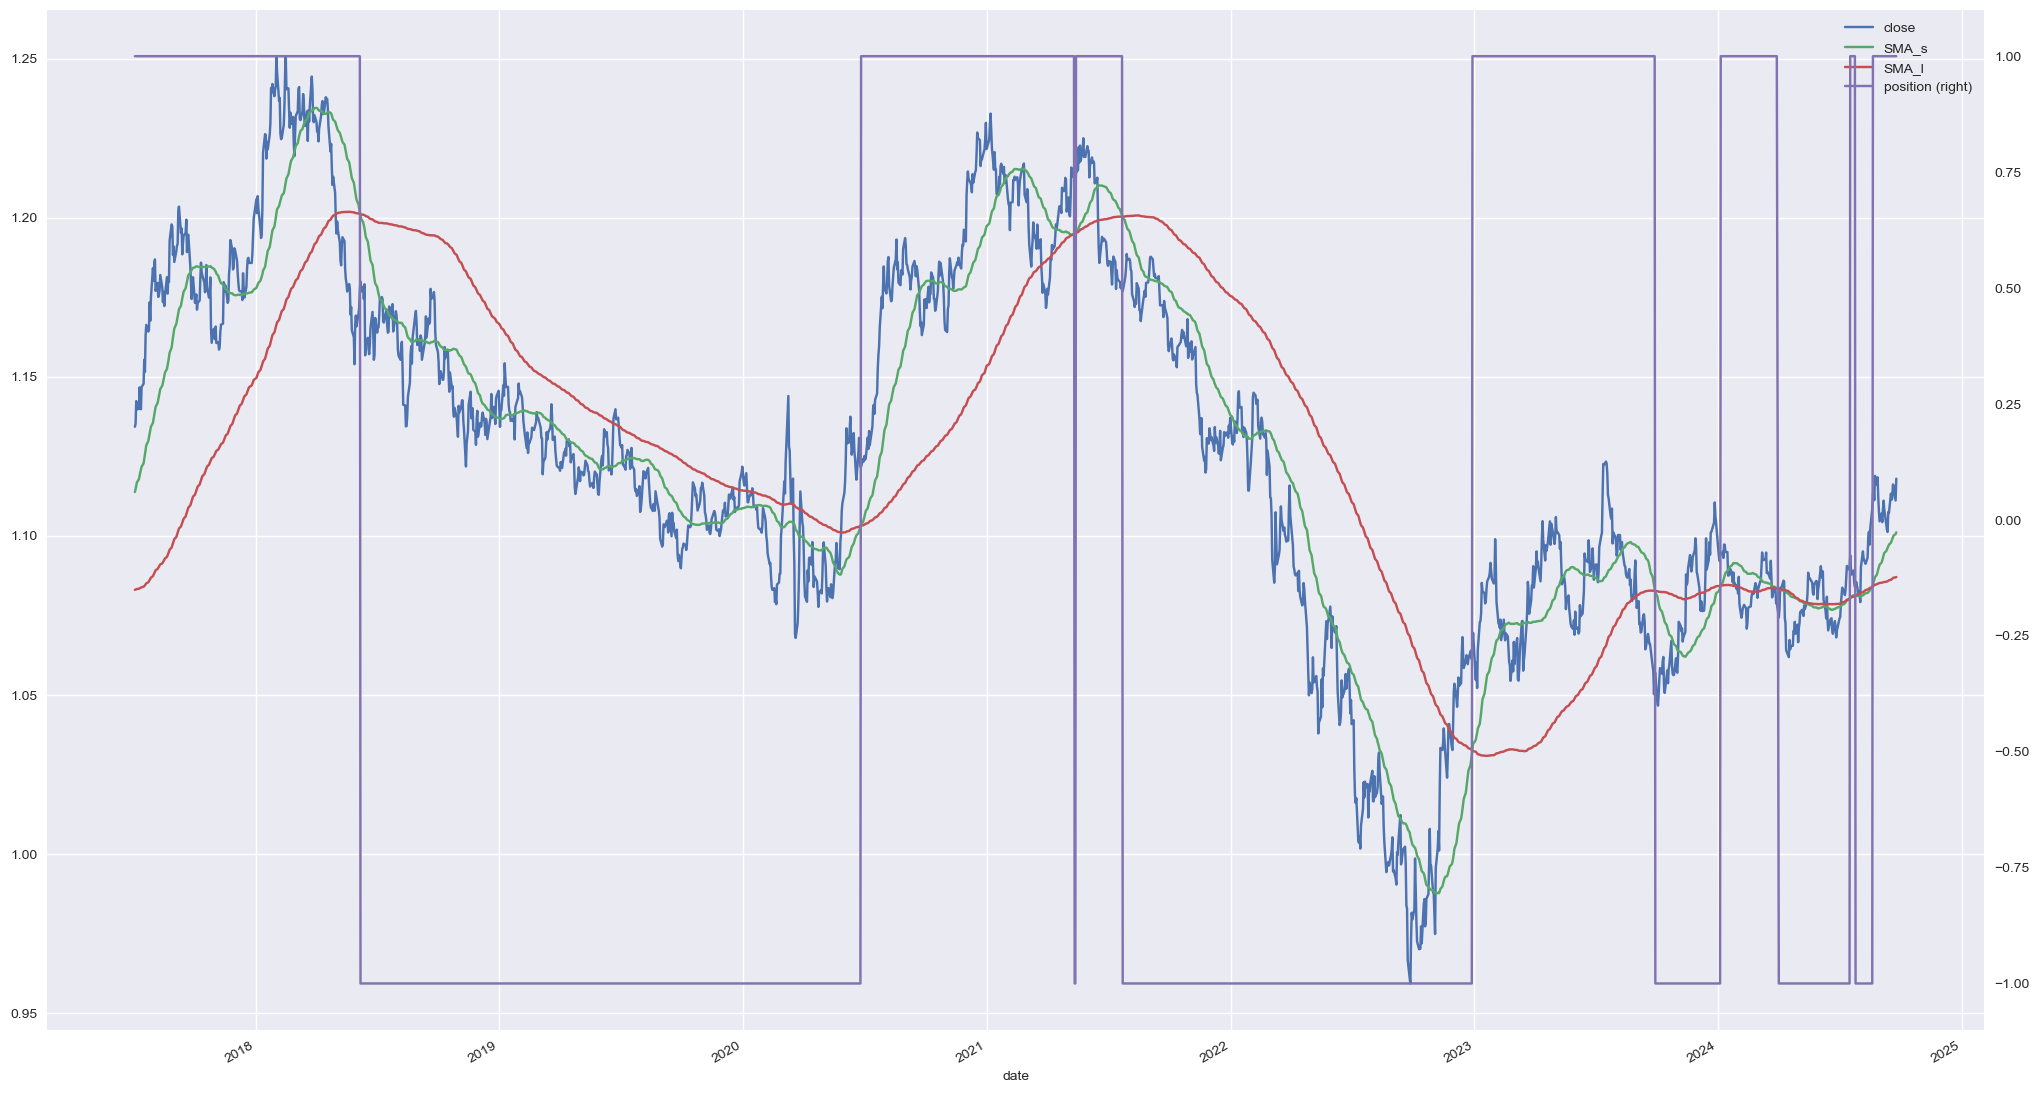

In [45]:
df.plot(secondary_y="position",figsize=(25,15))

# Backtesting

In [46]:
df["logret"]=np.log(df.close)-np.log(df.close.shift(1))

In [51]:
df.loc["2024-07"]

close     SMA_s     SMA_l  position    logret
date                                                       
2024-07-01  1.07405  1.077635  1.078640        -1  0.002704
2024-07-02  1.07450  1.077723  1.078691        -1  0.000419
2024-07-03  1.07850  1.077896  1.078788        -1  0.003716
2024-07-04  1.08115  1.078060  1.078907        -1  0.002454
2024-07-05  1.08370  1.078350  1.079074        -1  0.002356
2024-07-08  1.08240  1.078557  1.079204        -1 -0.001200
2024-07-09  1.08135  1.078853  1.079326        -1 -0.000971
2024-07-10  1.08300  1.079094  1.079503        -1  0.001525
2024-07-11  1.08680  1.079380  1.079703        -1  0.003503
2024-07-12  1.09055  1.079671  1.079905        -1  0.003445
2024-07-15  1.08940  1.079924  1.080077        -1 -0.001055
2024-07-16  1.08995  1.080214  1.080235        -1  0.000505
2024-07-17  1.09390  1.080596  1.080421         1  0.003617
2024-07-18  1.08965  1.080826  1.080567         1 -0.003893
2024-07-19  1.08780  1.081043  1.080696         1 -0.001699
2024-07-22  1.08910  1.081246  1.080878         1  0.001194
2024-07-23  1.08530  1.081315  1.081051         1 -0.003495
2024-07-24  1.08395  1.081226  1.081191         1 -0.001245
2024-07-25  1.08455  1.081184  1.081325        -1  0.000553
2024-07-26  1.08550  1.081158  1.081484        -1  0.000876
2024-07-29  1.08210  1.081087  1.081604        -1 -0.003137
2024-07-30  1.08150  1.081010  1.081715        -1 -0.000555
2024-07-31  1.08255  1.081016  1.081793        -1  0.000970

Il rendimento che ho ogni giorno è dato dal rendimento preso col segno attuale se ho una posizione LONG, mentre è dato da meno il rendimento se ho una posizione SHORT.

Attenzione: il segnale che noi riceviamo lo possiamo applicare soltanto AL GIORNO SEGUENTE perché il prezzo del giorno lo abbiamo solo a fine giornata, quindi tutta la colonna delle posizioni va spostata in avanti di un giorno!

In [52]:
df["strategy"]=df.logret * df.position.shift(1)

In [53]:
df.loc["2024-07"]

close     SMA_s     SMA_l  position    logret  strategy
date                                                                 
2024-07-01  1.07405  1.077635  1.078640        -1  0.002704 -0.002704
2024-07-02  1.07450  1.077723  1.078691        -1  0.000419 -0.000419
2024-07-03  1.07850  1.077896  1.078788        -1  0.003716 -0.003716
2024-07-04  1.08115  1.078060  1.078907        -1  0.002454 -0.002454
2024-07-05  1.08370  1.078350  1.079074        -1  0.002356 -0.002356
2024-07-08  1.08240  1.078557  1.079204        -1 -0.001200  0.001200
2024-07-09  1.08135  1.078853  1.079326        -1 -0.000971  0.000971
2024-07-10  1.08300  1.079094  1.079503        -1  0.001525 -0.001525
2024-07-11  1.08680  1.079380  1.079703        -1  0.003503 -0.003503
2024-07-12  1.09055  1.079671  1.079905        -1  0.003445 -0.003445
2024-07-15  1.08940  1.079924  1.080077        -1 -0.001055  0.001055
2024-07-16  1.08995  1.080214  1.080235        -1  0.000505 -0.000505
2024-07-17  1.09390  1.080596  1.080421         1  0.003617 -0.003617
2024-07-18  1.08965  1.080826  1.080567         1 -0.003893 -0.003893
2024-07-19  1.08780  1.081043  1.080696         1 -0.001699 -0.001699
2024-07-22  1.08910  1.081246  1.080878         1  0.001194  0.001194
2024-07-23  1.08530  1.081315  1.081051         1 -0.003495 -0.003495
2024-07-24  1.08395  1.081226  1.081191         1 -0.001245 -0.001245
2024-07-25  1.08455  1.081184  1.081325        -1  0.000553  0.000553
2024-07-26  1.08550  1.081158  1.081484        -1  0.000876 -0.000876
2024-07-29  1.08210  1.081087  1.081604        -1 -0.003137  0.003137
2024-07-30  1.08150  1.081010  1.081715        -1 -0.000555  0.000555
2024-07-31  1.08255  1.081016  1.081793        -1  0.000970 -0.000970

In [54]:
df.dropna(inplace=True)

In [55]:
df[["logret","strategy"]].sum()

logret     -0.014519
strategy    0.115639
dtype: float64

In [56]:
# rendimento medio giornaliero 
print(df.logret.mean(),df.strategy.mean())
# rendimento mediano giornaliero 
print(df.logret.median(),df.strategy.median())
# volatilità (dei ritorni giornalieri)
print(df.logret.std(),df.strategy.std())
# ----> rendimento assoluto
print(df.logret.sum(),df.strategy.sum())

-7.74763584268112e-06 6.170719297178124e-05
2.128157654235352e-05 4.396569513437365e-05
0.0044504642983434544 0.004450043001824943
-0.014519069569184417 0.11563927962911803


In [57]:
# rendimento medio annualizzato 
print(df.logret.mean()*251,df.strategy.mean()*251)
# rendimento mediano annualizzato 
print(df.logret.median()*251,df.strategy.median()*251)
# volatilità (dei ritorni giornalieri) annualizzata
print(df.logret.std()*np.sqrt(251),df.strategy.std()*np.sqrt(251))
# ----> rendimento assoluto annualizzato
print(df.logret.sum()*251/(df.index[-1]-df.index[0]).days,df.strategy.sum()*251/(df.index[-1]-df.index[0]).days)

-0.001944656596512961 0.01548850543591709
0.0053416757121307334 0.011035389478727786
0.0705086147231546 0.07050194013104091
-0.001381458097750299 0.011002827591701526


In [58]:
# dato che il LOG return può essere fuorviante, vediamo il valore di 1 come è diventato:
np.exp(df.logret.sum())

0.9855858238561226

In [59]:
# massimo drawdown
(df.strategy.cumsum().cummax()-df.strategy.cumsum()).max()

0.230167936420508

<Axes: xlabel='date'>

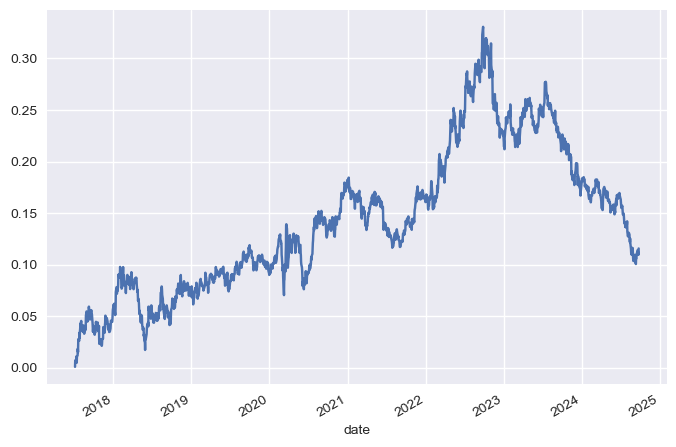

In [60]:
df.strategy.cumsum().plot()
# non è molto stabile nel tempo.

# Trovare i parametri ottimali

In [63]:
# WITH OANDA
df = api.get_history(instrument = "EUR_USD", start = "2016-09-24", end = "2024-09-24", granularity = "D", price = "B")
# we change the column names to match IBKR
df.rename(columns={"o":"open","h":"high","l":"low","c":"close","time":"date"},inplace=True)
df.index.names = ['date']
df = df.close.to_frame()

In [64]:
# WITH IBKR
df = pd.DataFrame(ib.reqHistoricalData( Forex("EURUSD"), endDateTime = "20240924 00:00:00", 
                                  barSizeSetting="1 day", durationStr="8 Y", 
                                  whatToShow= "BID", useRTH = True, formatDate=2 )).set_index("date")
df.index=pd.to_datetime(df.index)
df = df.close.to_frame()

In [65]:
df["logret"]=np.log(df.close)-np.log(df.close.shift(1))
def test_strategy(SMA):
    data=df.copy()
    data["SMA_s"]=data.close.rolling(SMA[0]).mean()
    data["SMA_l"]=data.close.rolling(SMA[1]).mean()
    data.dropna(inplace=True)
    data["position"]=np.where(data.SMA_s > data.SMA_l,+1,-1)
    data["strategy"]=data["logret"]*data.position.shift(1)
    data.dropna(inplace=True)
    return data["strategy"].mean()
    

In [66]:
test_strategy((50,200))

6.170719297178124e-05

In [67]:
test_strategy((75,150))

8.759692227898019e-05

In [68]:
test_strategy((25,250))

3.5963979664765144e-05

In [69]:
SMA_s_range=range(10,50,1)
SMA_l_range=range(100,250,1)

In [70]:
from itertools import product
# crea il prodotto cartesiano di due range

In [71]:
list(product(SMA_s_range,SMA_l_range))

[(10, 100),
 (10, 101),
 (10, 102),
 (10, 103),
 (10, 104),
 (10, 105),
 (10, 106),
 (10, 107),
 (10, 108),
 (10, 109),
 (10, 110),
 (10, 111),
 (10, 112),
 (10, 113),
 (10, 114),
 (10, 115),
 (10, 116),
 (10, 117),
 (10, 118),
 (10, 119),
 (10, 120),
 (10, 121),
 (10, 122),
 (10, 123),
 (10, 124),
 (10, 125),
 (10, 126),
 (10, 127),
 (10, 128),
 (10, 129),
 (10, 130),
 (10, 131),
 (10, 132),
 (10, 133),
 (10, 134),
 (10, 135),
 (10, 136),
 (10, 137),
 (10, 138),
 (10, 139),
 (10, 140),
 (10, 141),
 (10, 142),
 (10, 143),
 (10, 144),
 (10, 145),
 (10, 146),
 (10, 147),
 (10, 148),
 (10, 149),
 (10, 150),
 (10, 151),
 (10, 152),
 (10, 153),
 (10, 154),
 (10, 155),
 (10, 156),
 (10, 157),
 (10, 158),
 (10, 159),
 (10, 160),
 (10, 161),
 (10, 162),
 (10, 163),
 (10, 164),
 (10, 165),
 (10, 166),
 (10, 167),
 (10, 168),
 (10, 169),
 (10, 170),
 (10, 171),
 (10, 172),
 (10, 173),
 (10, 174),
 (10, 175),
 (10, 176),
 (10, 177),
 (10, 178),
 (10, 179),
 (10, 180),
 (10, 181),
 (10, 182),
 (10

In [72]:
combinazioni = list(product(SMA_s_range,SMA_l_range))

In [73]:
len(combinazioni)

6000

In [74]:
risultati=[]
for comb in combinazioni:
    risultati.append(test_strategy(comb))

In [75]:
np.max(risultati)

0.00014737910925065407

In [76]:
np.argmax(risultati)

3306

In [77]:
combinazioni[5924]

(49, 174)

In [78]:
AllResults=pd.DataFrame(combinazioni,columns=["SMA_s","SMA_l"])

In [79]:
AllResults.head()

SMA_s  SMA_l
0     10    100
1     10    101
2     10    102
3     10    103
4     10    104

In [80]:
AllResults["performance"]=risultati

In [81]:
AllResults.head()

SMA_s  SMA_l  performance
0     10    100     0.000056
1     10    101     0.000043
2     10    102     0.000050
3     10    103     0.000055
4     10    104     0.000045

In [82]:
AllResults.nlargest(20,"performance")

SMA_s  SMA_l  performance
3306     32    106     0.000147
3458     33    108     0.000147
3310     32    110     0.000146
3459     33    109     0.000144
3455     33    105     0.000144
3308     32    108     0.000143
3605     34    105     0.000143
3307     32    107     0.000143
3011     30    111     0.000140
3456     33    106     0.000139
2581     27    131     0.000138
3013     30    113     0.000137
3010     30    110     0.000137
3311     32    111     0.000136
3305     32    105     0.000136
3012     30    112     0.000136
3607     34    107     0.000135
3014     30    114     0.000135
2722     28    122     0.000133
3309     32    109     0.000133

In [83]:
AllResults.nsmallest(10,"performance")

SMA_s  SMA_l  performance
298     11    248    -0.000013
297     11    247    -0.000011
448     12    248    -0.000010
447     12    247    -0.000010
299     11    249    -0.000009
449     12    249    -0.000008
597     13    247    -0.000006
296     11    246    -0.000006
590     13    240    -0.000006
295     11    245    -0.000005

<Axes: xlabel='SMA_l', ylabel='SMA_s'>

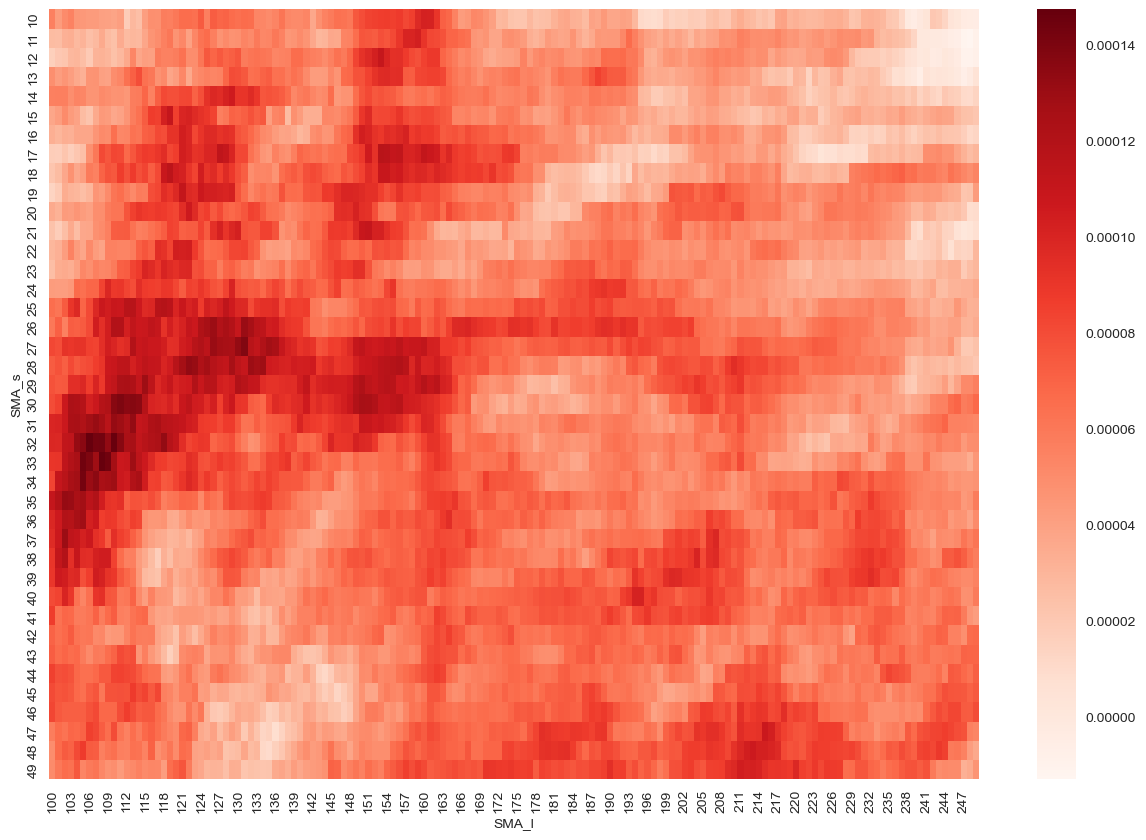

In [84]:
AllResultsTable=AllResults.pivot(index="SMA_s", columns="SMA_l", values="performance")
import seaborn
plt.figure(figsize=(15,10))
seaborn.heatmap(AllResultsTable,cmap="Reds")

In [85]:
ib.disconnect()